# Session 0: Start up

### Log into lxplus
ssh -Y <username>@lxplus.cern.ch -L localhost:XXXX:localhost:XXXX

### Set up CMSSW environment
source /cvmfs/cms.cern.ch/cmsset_default.sh  
scram p cmssw CMSSW_13_2_5  
cd CMSSW_13_2_5/src  
cmsenv

### Open jupyter notebook
jupyter notebook --no-browser --port=XXXX

In [1]:
import ROOT
from tqdm import tqdm
import numpy as np

Welcome to JupyROOT 6.26/11


# Session 1: HcalNano

NanoADD format is a plain tree/tuple with simple branches in root file, helping analysis to be performed without complicated CMSSW analyzers.

In [ ]:
%%bash
export input_file=root://eoscms.cern.ch//store/group/dpg_hcal/comm_hcal/RAW/HLTPhysics/RAW/v1/000/366/821/00000/0335a05c-8b31-49e7-99f0-254eef65485e.root
export output_file=my_test_output.root
cmsDriver.py NANO \
    -s RAW2DIGI,RECO,USER:DPGAnalysis/HcalNanoAOD/hcalNano_cff.hcalNanoTask \
    --processName=MyHcalNanoTest \
    --datatier NANOAOD \
    --eventcontent NANOAOD \
    --filein $input_file \
    --fileout $output_file \
    -n 10 \
    --nThreads 4 \
    --conditions auto:run3_data_prompt \
    --era Run3 \
    --python_filename my_cms_config.py \
    --no_exec \
    ## --customise DPGAnalysis/HcalNanoAOD/customiseHcalCalib_cff.customiseHcalCalib ## used for testEnablesEcalHcal stream
cmsRun my_cms_config.py

In [ ]:
file = ROOT.TFile("my_test_output.root")
tree = file.Get("Events")
for i, branch in enumerate(tree.GetListOfBranches()):
    if i>100: break
    print(branch.GetName())

# Session 2: Reconstructed Hits in HCAL
## Introduction
The HCAL detectors were designed to measure the energy of neutral and charged particles originating from quark fragmentation and hadronization. Optical signals produced by particle interactions in the HB and HE scintillators are carried through fibers to hybrid photodiodes (HPD), where they are converted to electric signals. Then, the analog signals from the HPDs are converted to digital signals by an electric circuit called the QIE (charge Integrator and Encoder). The QIE collects the charge produced by the HPD, integrates it over 25ns interval and digitizes the signal.

## Pulse shape in HCAL
If we look at the pulse shape before it is integrated over 25 ns intervals, it looks like the plot below. This plot shows the fraction of charge at each ns vs time.

<img src="notebookplots/DP-18-018-HE-pulse.png" alt="Alt Text" width="50%" height="50%">

Look how there is almost no signal below 100 ns and suddenly we have a peak starting at 100 ns. Actually, there is no need for us to keep the charge collected at each ns. Since we have collisions every 25 ns, let’s have 25 ns granularity and integrate the charge each 25 ns (this is what QIEs do). We call each 25 ns a time slice.

## Look at the pulse shape in a run
Let’s look at the pulse shape after QIE charge integration in a run taken in 2015 (heavy ion collisions). 

101it [00:45,  2.21it/s]
Warning in <TROOT::Append>: Replacing existing TH1: PulseShape (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: MC_Data


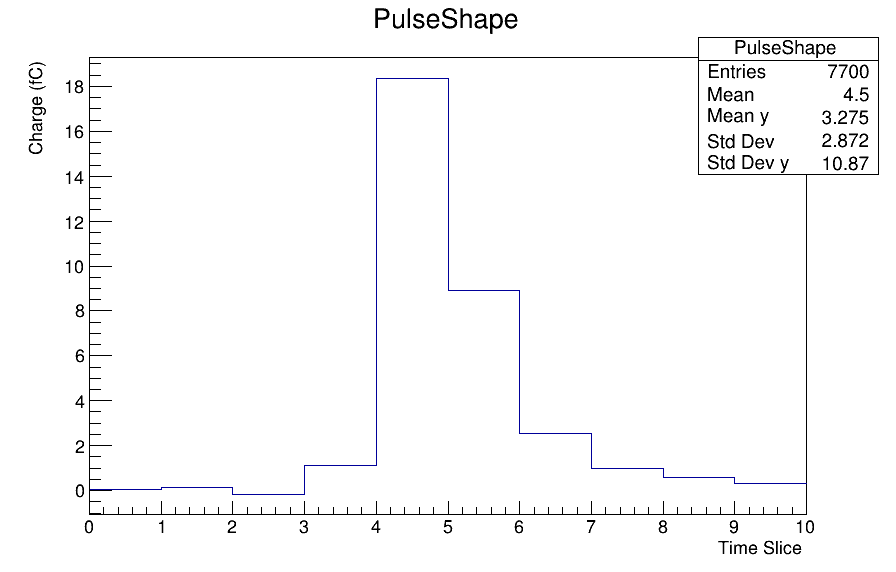

In [12]:
chain = ROOT.TChain("ExportTree/HcalTree")
chain.Add("/eos/cms/store/group/dpg_hcal/comm_hcal/CMS_POS/RecHits/HCALTree_run_261395.root")

PulseShape =  ROOT.TProfile("PulseShape", "PulseShape;Time Slice;Charge (fC)", 10,0,10);

TS = [0] * 10
sumQ = 0
ped = 0


for i, event in tqdm(enumerate(chain)):
    if i>100: break
    for j in range(event.PulseCount):
        if abs(event.IEta[j])>27 or ( abs(event.IEta[j])>14 and abs(event.IEta[j])<19): continue
        if event.Charge[j*10+0] == event.Charge[j*10+4] and event.Charge[j*10+4] == event.Charge[j*10+5]: continue

        sumQ=0
        ped=0
        
        for k in range(3): ped+=event.Charge[j*10+k]+event.Pedestal[j*10+k]
        for k in range(3,7): sumQ+=event.Charge[j*10+k]+event.Pedestal[j*10+k]
        
        ped/=3
        sumQ-=4*ped
        
        for k in range(0, 10): TS[k] = event.Charge[j*10+k]+event.Pedestal[j*10+k]-ped
        
        if sumQ<5 or TS[4]<5 or ped<0 or TS[3]<0 or TS[5]<0 or TS[6]<0: continue
        
        for k in range(0, 10): PulseShape.Fill(k, TS[k])
            
c = ROOT.TCanvas("MC_Data","",900,600)
PulseShape.Draw("HIST")
c.Update()
c.Draw()


In [ ]:
%%bash
root -l
.L Pulse_shape.C
Pulse_shape("/eos/cms/store/group/dpg_hcal/comm_hcal/CMS_POS/RecHits/HCALTree_run_261395.root")
.q

In the plot you just made, we have time slices on the x-axis (each time slice is 25 ns). This plot gives you all the charge a QIE has received in each 25 ns in HB. Note that this is a TProfile, meaning that the plot is an average of all QIEs in HB.

Looking at the plot, we always have the peak at TS4. Actually, we time HCAL in a way that the peak of charge from QIEs is always in TS4. (if it arrives earlier, we delay the response of QIE to have the peak at TS4). When HCAL sees a peak, it saves four TS before and five TS after (totally 10 TS from TS0 to TS9) and then corresponds this hit to the right bunch crossing. If it happens that the peak is 25 ns earlier or later (i.e. in TS3 or TS5), HCAL will assign the hit to the wrong bunch crossing. We will come back to this when we talk about out-of-time pile-up.

## Method-0 energy reconstruction
The easiest thing that comes to mind to measure the energy of a hit is to just simply add up all charges from all 10 TS and convert them to energy using the look-up tables (look-up tables are tables that convert fC to GeV). This simplest algorithm to calculate the energy of a hit is called method-0 and was used in run 1 (2009 – 2013) because in run 1, we had collisions every 50 ns instead of 25 ns. We will see why we should be more careful when bunch spacing is shorter.

## Out-of-time Pile-up
Now let’s see what will happen if we have two hits from two consecutive bunch crossings in the same scintillator. In this case the second hit is 25 ns after the first one. But since the response time of HBDs are more than 25 ns, two hits will mix:
<img src="notebookplots/OOT-PU.png" alt="text" width="80%" height="80%">

It looks like method-0 is not very accurate when we have more than one hit. We need a way to recognize pulses with more than one hit and treat them differently. Look how pulse shapes are different when we have only one hit and when we have two hits. The change in pulse shape is what we can use to distinguish pulses with only one hit and pulses with more than one hit.

The pulse shape we looked at in the beginning of this exercise was from a lead-lead collision taken in 2015 with isolated bunches. Therefore, the bunch crossings were far enough not to affect each other. Now let’s look at a run with bunch spacing of 25 ns. It’s a proton-proton collision run taken in 2017. Do:

In [ ]:
%%bash
root -l
.L Pulse_shape.C
Pulse_shape("/eos/cms/store/group/dpg_hcal/comm_hcal/CMS_POS/RecHits/HCALTree_run_301998.root")
.q

## Method-2 / Mahi energy reconstruction






## Method-3 energy reconstruction
The last reconstruction method is called Method-3. Method-3 is a lighter version of method-2 that can be used online by fitting 3 TS. it provides similar pile-up mitigation as method-2 with smaller computing time.

## Comparison between different reconstructions methods
In method-2, method-3 and Mahi (unlike method-0) we reconstruct the energy of the hit that we are interested in (i.e. the hit that peaks at TS4) from the pulse shape. Let’s compare the energies reconstructed by method-0, method-2 and method-3. Do:

# Session 4: Isotrack Calibration
## Introduction
The real detector geometry differs from the testbeam geometry where calibration factors were extracted for the first time. Therefore, HCAL experts use several methods to recalibrate the detector. One of the recalibration methods is to use Isolated Charged Hadrons. This exercise will briefly describe how this recalibration is done in HCAL.
## Calibratio method
CMS has a very powerful magnet, the momentum measured by the tracker is accurate. The tracker measures the momentum of charged particles through their curvature. If a particle is very high energy, it will appear like a straight line to the tracker. Therefore, the curvature will be very little and the measurement of momentum is not accurate. This is where the measurement of energy by HCAL is more precise than the momentum measured by the tracker. Obviously, HCAL is also used to measure the energy of neutral hadrons that can't be done by the tracker.

Although radiation damages HCAL, it has no effect on the magnetic field, therefore, the energy measured by the tracker can be used as a reference for HCAL calibration. This method of calibration uses “isolated charged hadrons” for calibration because:
- Charged: Obviously, if we want to use the magnetic field to measure the energy of a particle, that particle should have charge.
- Isolated: We require the particle to be isolated from other particles to ensure minimal contamination from unrelated energy depositions.
- Hadron: We would like the particle to deposit its energy in HCAL, therefore the particle should be a hadron.

Low and high energy isolated charged hadrons are not desirable in the calibration. Because:
- HCAL has a non-linear response with respect to the initial energy of the hadrons which is more prominent at lower energies. Therefore, we don’t want to consider low energy hadrons.
- There is only a low number of isolated hadrons with high energy as the energy spectrum falls down with increasing energy.

For this reason, an energy of 50 GeV is chose and only particles with momenta between 40-60 GeV are considered.

### Measurement uncertainties
Now that we know how we want to calibrate HCAL, let’s look at the uncertainties of measuring energy/momentum in HCAL/tracker. There are a few sources of uncertainty measuring the energy of isolated charged hadrons:
- Primary vertex and track reconstruction quality:Tracks are required to have an associated primary vertex and to have the track quality bit set to “high purity”.
- Interaction of hadrons with ECAL:The hadron calorimeter does not measure the entire energy of particles. The particles can interact and deposit a substantial part of their energy in the preceding electromagnetic calorimeter (ECAL) or other dead material before the hadron calorimeter. The depth of ECAL is about one nuclear interaction length and more than half of hadrons undergo inelastic interaction in the ECAL. In order to have better accuracy, hadrons that have had high interaction with ECAL are not considered. This is ensured by requiring that the energy measured in ECAL in a cone of radius 14 cm around the impact point of the track to be less than 1 GeV.

In [ ]:
%%bash

root -l
.L testOfIsotrackPUcorrection.C 
calculateResponse("/eos/cms/store/group/dpg_hcal/comm_hcal/suman/13p6TeV/2023EraD/","Commissioning_2023EraD4060",-1,-1,25,0,1.5,10,"test")
calculateResponse("/eos/cms/store/group/dpg_hcal/comm_hcal/suman/13p6TeV/2023EraD/","Commissioning_2023EraD4060",-1,-1,25,1,1.5,10,"test")
.q

In [ ]:
%%bash
ls

In [ ]:
file = ROOT.TFile("test_noCor_Commissioning_2023EraD4060_const10_p40-60_pt07_eh10_ee1_rings1_1.5rms.root","read")
#file.ls()
keys = file.GetListOfKeys()

canv = ROOT.TCanvas("plots with PU", "plots with PU", 1200, 6000)
canv.Divide(4,20)

# Loop over the keys and print their names
for i, key in enumerate(keys, start=1):
    key_name = key.GetName()
    key_type = key.GetClassName()
    #print(f"Key name: {key_name}, key type: {key_type}")
    canv.cd(i)
    hist = file.Get(key.GetName())
    hist.Draw()
    
canv.Update()
canv.Draw()

In [ ]:
file = ROOT.TFile("test_cor03_Commissioning_2023EraD4060_const10_p40-60_pt07_eh10_ee1_rings1_1.5rms.root","read")
#file.ls()
keys = file.GetListOfKeys()

canv = ROOT.TCanvas("plots with PU", "plots with PU", 1200, 6000)
canv.Divide(4,20)

# Loop over the keys and print their names
for i, key in enumerate(keys, start=1):
    key_name = key.GetName()
    key_type = key.GetClassName()
    #print(f"Key name: {key_name}, key type: {key_type}")
    canv.cd(i)
    hist = file.Get(key.GetName())
    hist.Draw()
    
canv.Update()
canv.Draw()


Let’s look at plots "e2pHB", "e2pHE", "e2pTR" and "e2pALL". These plots show response corrections in HB and HE.

<span style="color:black; background-color:red; font-weight:bold;">Question: Why don’t we calibrate HF in isotrack calibration method?</span>

<span style="color:black; background-color:red; font-weight:bold;">Question: What does transition region mean in the title of plot “e2pTR”?</span>


The plots show the distribution of $$\frac{E_{HCAL}}{p_{track}-E_{ECAL}}$$, which is a Gaussian. The red smooth curve is a Gaussian fit to the plot in the range -1.5 to 1.5 standard deviations. Look at the tails in the plots. Although the central part of the plot is Gaussian, the long tails on either side don’t look Gaussian. The tail on the lower side may be due to non-containment of the hadron shower in the HCAL and the tail on the higher side is most likely due to overlap of showers from some neighboring particles in the jet (most likely neutral ones).

Now look at ieta plots (from ieta -24 to ieta 24). We want to find the correction factor for each ieta separately.

<span style="color:black; background-color:red; font-weight:bold;">Question: Why do we need to find a correction factor separately for each ieta and not each iphi?</span>

The mean value of $$\frac{E_{HCAL}}{p_{track}-E_{ECAL}}$$ is our correction factor, i.e this is the factor that compensates for radiation damage. But it would be nice if we could remove long tails before calculating the mean. In order to do so, we find the center of the fitted curve instead of the mean of the whole distribution. Look at plots “respMean” and “respFit”. Can you explain what the difference is between these two plots? Look at all the plots again. Do you understand all of them? Guess what other plots are from their title. The “chi2/ndf” plot is chi-square divided by NDF (Number of Degrees of Freedom). Chi-square is a test for the goodness of a fit. What does “chi2/ndf” plot tell you?

## Correction for pile-up
### Correcion method
When there is much energy near the cone from other tracks, there will also be contribution inside the cone, so the true energy is probably lower than that reconstructed in the cone. And if the energy deposition outside the cone is caused by the particle itself, the true energy will be higher than that reconstructed in the cone. We use a 70-cm wide (Rcone = 35 cm) cone when measuring the energy of particles. If there is any energy deposition from a nearby track in our 70-cm wide cone, the energy beyond the cone (radius > Rcone) should be higher than normal.

It is found that looking at the energy deposition between Rcone + 10 cm and Rcone + 30 cm has better results because we still have some energy from the selected isolated track between Rcone and Rcone + 10 cm. We show the energy between Rcone + 10 cm and Rcone + 30 cm by ∆.

<img src="./notebookplots/delta4PUcorrection.png " alt="Alt Text" width="80%" height="80%">

### Compare MC samples with and without pile-up

In [ ]:
Chain_noPU = ROOT.TChain("hcalIsoTrkAnalyzer/CalibTree")
Chain_noPU.Add("/eos/cms/store/group/dpg_hcal/comm_hcal/suman/13p6TeV/WinterMC23noPU/IsoTrkCalib_MC_Winter23_noPU.root")
for branch in Chain_noPU.GetListOfBranches(): print(branch.GetName())

Hist_noPU = ROOT.TProfile("no_PU", ";ieta;#Delta (GeV)", 60, -30, 30)

for i, event in tqdm(enumerate(Chain_noPU)): 
    if i>10000: break
    if abs(event.t_ieta) > 25: continue
    if event.t_selectTk and event.t_qltyMissFlag and event.t_qltyPVFlag:
        Hist_noPU.Fill(event.t_ieta, event.t_eHcal30 - event.t_eHcal10)


        
Chain_PU = ROOT.TChain("hcalIsoTrkAnalyzer/CalibTree")
Chain_PU.Add("/eos/cms/store/group/dpg_hcal/comm_hcal/suman/13p6TeV/WinterMC23PU/IsoTrkCalib_MC_Winter23_PU_v21.root")
#for branch in Chain_noPU.GetListOfBranches(): print(branch.GetName())

Hist_PU = ROOT.TProfile("PU", ";ieta;#Delta (GeV)", 60, -30, 30)

for i, event in tqdm(enumerate(Chain_PU)): 
    if i>10000: break
    if abs(event.t_ieta) > 25: continue
    if event.t_selectTk and event.t_qltyMissFlag and event.t_qltyPVFlag:
        Hist_PU.Fill(event.t_ieta, event.t_eHcal30 - event.t_eHcal10)


c1 = ROOT.TCanvas("MC_Data","",900,600)

leg = ROOT.TLegend(0.8,0.85,0.95,0.95)
leg.AddEntry(Hist_noPU, "no PU")
leg.AddEntry(Hist_PU, "with PU")

Hist_noPU.SetMaximum(50)
Hist_noPU.SetMinimum(0)
Hist_noPU.SetLineColor(ROOT.kBlue)
Hist_noPU.SetStats(0)
Hist_noPU.Draw()

Hist_PU.SetLineColor(ROOT.kRed)
Hist_PU.Draw("same")

leg.Draw()
c1.Update()
c1.Draw()


### Correction Formula
In order to make up for PU, we correct the energy measured by HCAL using this formula:

<img src="notebookplots/parametrisation2019.png " alt="Alt Text" width="60%" height="60%">  
<img src="./notebookplots/parameters2018.png " alt="Alt Text" width="60%" height="60%">

Where E is the energy in the signal cone Rcone = 35 cm around the impact point of the selected isolated track, p is the track momentum and ∆ is the energy deposition in the annulus around the main cone as explained above. The coefficients are determined by asking the energy measured by HCAL be equal to the track momentum minus ECAL energy (in MC)

The quadratic term (third term) can be explained by the fact that there is also some fraction of pion energy outside the cone, in particular for low-energy showers that tend to be wider. Accounting for them works in opposite direction and thus lessens the correlation between the reconstructed pion energy and pileup energy deposited near the cone. Therefore, the correction for low-energy showers should be suppressed with respect to high-energy ones.